In [10]:
import numpy
import tensorflow as tf
import scipy.io as io
import matplotlib.pyplot as plt

%matplotlib inline

label_dict = {
    'N':0,
    'A':1,
    'O':2,
    '~':3
}

In [56]:
#%%prun
data = []
label = []
lens = []

annotations = open('./training2017/REFERENCE.csv', 'r').read().splitlines()
for line in annotations:
    fname, label_str = line.split(',')
    
    x = io.loadmat('./training2017/'+fname+'.mat')['val'].squeeze()
    data.append(x)
    
    y = label_dict[label_str]
    label.append(y)
    
    lens.append(len(x))
    
assert(len(label) == len(data))

(array([  319.,   260.,   218.,   168.,  6284.,   150.,    93.,    69.,
           48.,   919.]),
 array([  2714. ,   4271.2,   5828.4,   7385.6,   8942.8,  10500. ,
         12057.2,  13614.4,  15171.6,  16728.8,  18286. ]),
 <a list of 10 Patch objects>)

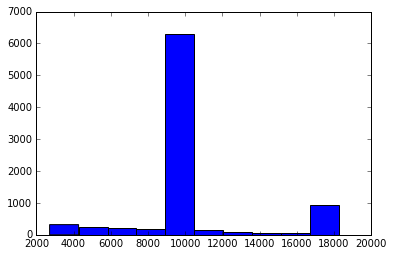

In [57]:
plt.hist(lens)

# TFRecords

## Write

In [47]:
def make_example(sequence, label):
    # The object we return
    ex = tf.train.SequenceExample()
    # A non-sequential feature of our example
    sequence_length = len(sequence)
    ex.context.feature['length'].int64_list.value.append(sequence_length)
    ex.context.feature['label'].int64_list.value.append(label)
    
    '''
    This is not working for some reason...
    ex.feature_lists\
        .feature_list['tokens']\
        .feature.add()\
        .int64_list.value.extend(sequence)
    '''
    fl_val = ex.feature_lists.feature_list['val']
    for token in sequence:
        fl_val.feature.add().float_list.value.append(token)

    return ex

In [48]:
def write_TFRecord(data, label, fname='train'):
    with open(fname + '.TFRecord', 'w') as fp:
        writer = tf.python_io.TFRecordWriter(fp.name)
        print('Sampling...')
        for i, (x, y) in enumerate(zip(data, label)):
            ex = make_example(x, y)
            
            writer.write(ex.SerializeToString())
            print('\r%05d'%i, end=' ', flush=True)
        writer.close()
        print("\nWrote to {}".format(fp.name))

In [49]:
write_TFRecord(data, label)

Sampling...
08527                                                         
Wrote to train.TFRecord


## Read

In [59]:
def parse_TFRecords_example(filename_queue):
    # Define how to parse the example
    
    reader = tf.TFRecordReader()
    _, example = reader.read(filename_queue)
    
    context_features = {
        'length': tf.FixedLenFeature([1], dtype=tf.int64),
        'label': tf.FixedLenFeature([1], dtype=tf.int64)
    }
    sequence_features = {
        'val': tf.FixedLenSequenceFeature([], dtype=tf.float32)
    }
    context_parsed, sequence_parsed = tf.parse_single_sequence_example(
        serialized=example,
        context_features=context_features,
        sequence_features=sequence_features
    )
    return context_parsed, sequence_parsed
parse_example = parse_TFRecords_example

# Tensorflow fetcher

In [60]:
#%%prun
filename_queue = tf.train.string_input_producer(['train.TFRecord'])
cont, seq = parse_example(filename_queue)

res = []
with tf.Session() as sess:
    
    coord = tf.train.Coordinator()
    
    sess.run(tf.global_variables_initializer())
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    
    for i in range(5): 
        res.append(cont['length'].eval())
        #print(res)
    coord.request_stop()
    coord.join(threads)
    sess.close()